# TuiGAN: Learning Versatile Image-to-Image Translation with Two Unpaired Images

Paper link:  https://arxiv.org/pdf/2004.04634.pdf

Authors: Jianxin Lin, Yingxue Pang, Yingce Xia, Zhibo Chen, Jiebo Luo

### Group Members

Bedirhan Uğuz e2172070

Özhan Suat e2171973

# Paper Summary

## Introduction 

General unsupervised image-to-image translation(UI2I) task deals with learning a mapping between two domains without paired images. Existing methods require lots of unpaired images from different domains. However, TuiGAN is a generative model that is trained on only two unpaired images. The images are translated in a coarse to fine manner. Gradually, TuiGAN refines from global structures to local details.
Here are the some examples from TuiGAN paper:
![fig1](imgs/fig1.png)

## Method

Given two images $I_A \in A$ and $I_B \in B$ where A and B are the two image domains, the goal is to convert $I_A$ to $I_{AB} \in B$ and $I_B$ to $I_{BA} \ in A$ without using any extra data. The translated results $I_{AB}$ and $I_{BA}$ should inherit the domain-invariant features of the source image and replace the domain-specific features with ones of the target image.

### Overall Architecture

TuiGAN exploits multiscale image pyramids to translate the images to another domain. Briefly, there are two symmetric pyramids of generators and discriminators. In each scale, the generator takes the downsampled source image and previously translated image to generate the new translated image and the discriminator learns the domain distribution by progressively narrowing the receptive fields. The whole framework is learned in a scale-to-scale fashion and the final result is obtained at the finest scale.
![fig2](imgs/fig2.png)

#### Image Translation:

At the coarsest level, $I_{AB} = G_{AB}(I_A)$, $I_{BA} = G_{BA}(I_B)$ 
where $G_{AB}: A \rightarrow B$ and $G_{BA}: B \rightarrow A$ are the mapping functions that we need to obtain.  This generators take input from one of the domains directly and do not take any other input different from other level’s generators. 

On the other hand, generators which are not at the coarsest level, take another input from the previous level. For example, when using a 250x250 input and scaling factor 0.75, the top level works with 250x250 real image and 250x250 generated image which is generated by the previous level and upsampled to 25x250 from 188x188. The image translation equation is $I_{AB} = G_{AB}(I_A, I_{AB}^{N-1})$, $I_{BA} = G_{BA}(I_B, I_{BA}^{N-1})$ 


### Generator Architecture

![fig3](imgs/fig3.png)

Generator architecture consists of two networks $\phi$ and $\psi$. The first one consists of 5 layers and is responsible for capturing the details in the current scale. On the other hand, the second has 4 layers and is responsible for generating an attention map that is used to fuse previous scale and the current scale. After fusing the current scale and previous scales, the output becomes ready.

Please note that all of the generators in the pyramids are sharing the same architecture.


### Discriminator

For each discriminator, the Markovian Discriminator(PatchGANs) is used and its architecture is exactly the same with the $\phi$ network architecture. At the end, we can say that we have PatchGANs with 11x11 patch size for discriminators. Note that it has 11x11 patch size because every pixel at the last layer of the discriminator has 11 receptive fields.

### Loss Functions

*WGAN-GP* is used as adversarial loss which can improve the training stability. 

The adversarial loss function: $L_{ADV}^n = D_B^n(I_B^n) - D_B^n(G_{AB}^n(I_A^n)) + D_A^n(I_A^n) - D_A^n(G_{BA}^n(I_B^n)) - \lambda_{PEN} (|| \nabla_{\hat{I}_B^n}D_B^n(\hat{I}_B^n) ||_2 - 1 )^2 - \lambda_{PEN} (|| \nabla_{\hat{I}_B^n}D_B^n(\hat{I}_B^n) ||_2 - 1 )^2$ 

*Cycle consistency loss* is used to contrain the model to retain inherent properties of input image after translation.
The cycle consistency loss function:

$L_{CYC}^n = ||I^n_{A} - I^n_{ABA} ||_1 + ||I^n_{B} - I^n_{BAB} ||_1$ where $I^n_{ABA} = G_{BA}^n(I_{AB}^n, I_{ABA}^{n+1 \uparrow}),I^n_{BAB} = G_{AB}^n(I_{BA}^n, I_{BAB}^{n+1 \uparrow})$ 

By using only adv. loss and cycle-consistency loss, the models end up with color and texture misaligned results. Therefore, *identity Loss* is used to tackle the problem on each scale.

$L_{IDT}^n = || I_A^n - I_{AA}^ ||_1 + || I_B^n - I_{BB}^ ||_1$ where $I_{AA}^n = G_{BA}^n(I_A^n, I_{AA}^{n+1 \uparrow}), I_{BB}^n = G_{AB}^n(I_B^n, I_{BB}^{n+1 \uparrow})$

In order to avoid pixelated and noisy results, *total variation loss* is used. Briefly, it helps to remove rough texture of the generated images by encouraging images to consist of several patches by calculating the differences of neighboring pixel values in the image.

$L_{TV}^n = L_{tv}(I_{AB}^n) + L_{tv}(I_{BA}^n), L_{tv}(x) = \sum_{i,j}\sqrt{(x[i, j+1] - x[i,j])^2 + (x[i+1, j] - x[i,j])^2}, x\in{\{I_{AB}^n, I_{AB}^n\}} $

## Evaluation

#### Single Image Frechet Inception Distance (SIFID): 
SIFID captures the difference of internal distributions between two images, which is implemented by computing the Frechet Inception Distance (FID) between deep features of two images

#### Perceptual  Distance  (PD): 
PD computes the perceptual distance between images. A lower PD score indicates that the content of two images is more similar.

#### User  Preference  (UP): 
User preference  studies are conducted for performance evaluation since the qualitative assessment is highly subjective.

## Applications

The method is used for GeneralUI2I Tasks, Image Style Transfer, Animal Face Translation and Painting-to-Image Translation, and reported in the paper.

# Training

### Module Imports


In [1]:
from models import *
from image_utils import *
from train_utils import *
from model_utils import *
import torch
from pathlib import Path
import random
from evaluation import *

### Data selection and CUDA device selection for multiple GPU 

The training can not be parallelized due to its architecture, so you need to train the models on a single GPU.
Moreover, training on CPU is not practical. We do not recommend it!
The authors are reported in the paper that the training lasts 3-4 Hrs with RTX2080ti.
We also observe the similar behaviour with RTX2080.

In [2]:
data_name = 'horse2zebra'
device_number = 0

### Hyperparameter  Settings,

In this section, you can find the hyperparameter settings.

In [3]:
# Path of image pairs.
pathA = f'{data_name}_A.jpg'
pathB = f'{data_name}_B.jpg'

#Prepare output directory
output_path = f'out_{data_name}'
Path(output_path).mkdir(exist_ok=True)

# Set hyperparameters specified in the paper.
DEVICE = f'cuda:{device_number}'
LR = 0.0005
LR_DECAY_STEP = 1600
SCALE_FACTOR = 0.75
NUM_ITERS = 4000
NUM_SCALES = 5

PHI_BLOCK_COUNT = 5
PSI_BLOCK_COUNT = 4

LAMBDA_CYC = 1
LAMBDA_IDT = 1
LAMBDA_TV = 0.1
LAMBDA_PEN = 0.1

# Print loss values and generated image pairs at each LOG_FREQ steps.
LOG_FREQ = 500

# Train generator and discriminator GEN_STEP and DISC_STEP times respectively at each iteration.
DISC_STEP = 3
GEN_STEP = 3

# Set random seeds to fixed variable to generate reproducable results.
torch.manual_seed(1641)
random.seed(1641)
np.random.seed(1641)

### Data Loading

We load data and create the image scale pyramid.

In [4]:
def load_images(path_a=pathA, path_b=pathB):
    # Read image from given path and resize them to 250x250.
    imgA, imgB = read_domains(dir_path='data', image_A_file=pathA, image_B_file=pathB, resize=True)

    # Normalize images by mapping them to [-1, 1].
    normed_imgA = normalize_image_to_tensor(imgA).to(DEVICE)
    listA = construct_scale_pyramid(normed_imgA)

    normed_imgB = normalize_image_to_tensor(imgB).to(DEVICE)
    listB = construct_scale_pyramid(normed_imgB)

    # Higher scale image is at lower index. So, we reversed image list to align them to model list.
    listA.reverse()
    listB.reverse()
    return listA, listB
listA, listB = load_images()

In [5]:
# Helper functions to visualize intermediate training results
def show_image(img_tensor):
    img = denormalize_image_from_tensor(img_tensor.detach().cpu())
    plt.imshow(img)
    plt.show()
    
def show_image_m(img1, img2):
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.show()

# To freeze network grad calculations.
def reset_grads(model,require_grad):
    for p in model.parameters():
        p.requires_grad_(require_grad)
    return model

In [12]:
# Start training for each scale from 0 to NUM_SCALES.
def train(listA, listB, models):
    for i in range(NUM_SCALES):
        train_scale(listA, listB, models, i)

# Train single scale.
def train_scale(listA, listB, models, model_idx):
    """
    :param listA: image pyramid for input image A.
    :param listB: image pyramid for input image B.
    :param models: model list which contains 4 model list. (A-to-B, B-to-A, disc. for A, disc. for B)
    :param model_idx: index of model of current scale. Same as scale number.
    :return: 
    """
    # Get real images for current scale.
    inpA = listA[model_idx]
    inpB = listB[model_idx]

    # Get models for current scale and change mode to train.
    gen_ab = models[0][model_idx]
    gen_ab.train()
    gen_ba = models[1][model_idx]
    gen_ba.train()

    disc_a = models[2][model_idx]
    disc_a.train()
    disc_b = models[3][model_idx]
    disc_b.train()
    
    # As, specified in paper we used Adam optimizer. For each type of model, different optimizer is created.
    # Also, we add momentum to converge better. The idea is taken from DCGAN paper.
    opt_g = torch.optim.Adam(gen_ab.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_g2 = torch.optim.Adam(gen_ba.parameters(), lr=LR, betas=(0.5, 0.999))
    
    opt_d = torch.optim.Adam(disc_a.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_d2 = torch.optim.Adam(disc_b.parameters(), lr=LR, betas=(0.5, 0.999))
    
    # Learning rate schedulers defined with decay step specified in paper.
    sched_d = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_d,milestones=[LR_DECAY_STEP],gamma=0.1)
    sched_g = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_g,milestones=[LR_DECAY_STEP],gamma=0.1)
    
    sched_d2 = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_d2,milestones=[LR_DECAY_STEP],gamma=0.1)
    sched_g2 = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_g2,milestones=[LR_DECAY_STEP],gamma=0.1)
    
    
    # Training loop. One iteration added to log last iteration correctly.
    for i in range(NUM_ITERS + 1):
        # Discriminator trained in multiple step which is originated from SinGAN supplementary material.
        for j in range(DISC_STEP):
            opt_d.zero_grad()
            opt_d2.zero_grad()
            prev_ab, prev_ba, prev_aba, prev_bab, curr_ab, curr_ba = generate_input((listA, listB),
                                                                                    models, model_idx, 
                                                                                    device=DEVICE)
            
            # Real image loss of discriminator.
            out_A = - disc_a(inpA).mean()
            out_B = - disc_b(inpB).mean()

            # Fake image loss of discriminator.
            out_gB = disc_b(curr_ab).mean()
            out_gA = disc_a(curr_ba).mean()

            # Gradient penalty 
            gradient_penalty_a = gradient_penalty(disc_a, inpA, curr_ba, device=DEVICE)
            grad_a = LAMBDA_PEN * gradient_penalty_a
            
            
            gradient_penalty_b = gradient_penalty(disc_b, inpB, curr_ab, device=DEVICE)
            grad_b = LAMBDA_PEN * gradient_penalty_b
                        
            # Total of all discriminator losses
            total_loss = out_A + out_B + out_gB + out_gA + grad_a + grad_b
            total_loss.backward()
            
            opt_d.step()
            opt_d2.step()

        # Generator trained in multiple step which is originated from SinGAN supplementary material.
        for j in range(GEN_STEP):
            opt_g.zero_grad()
            opt_g2.zero_grad()
            
            # Generates generators of previos scales outputs and current generators outputs.
            prev_ab, prev_ba, prev_aba, prev_bab, curr_ab, curr_ba = generate_input((listA, listB),
                                                                                    models, model_idx, device=DEVICE)
            # Adv. Loss
            adv_loss_ba = - disc_a(curr_ba).mean()
            adv_loss_ab = - disc_b(curr_ab).mean()

            # Cycle consistency loss
            loss = nn.L1Loss()
            curr_aba = gen_ba(curr_ab, prev_aba)
            l1_aba = LAMBDA_CYC * loss(inpA, curr_aba)
    
            curr_bab = gen_ab(curr_ba, prev_bab)
            l1_bab = LAMBDA_CYC * loss(inpB, curr_bab)
            
            # Generates A-to-A and B-to-B images to calculate identity loss by using generators of previous scales.
            # image A, model BA
            curr_aa = generate_identity(listA, models[1], model_idx, device=DEVICE)
            # image B, model AB
            curr_bb = generate_identity(listB, models[0], model_idx, device=DEVICE)

            # Identity loss
            idt_aa = LAMBDA_IDT * loss(inpA, curr_aa)

            idt_bb = LAMBDA_IDT * loss(inpB, curr_bb)
            
            
            # Total variation loss
            tv_ab = LAMBDA_TV * total_variation_loss(curr_ab)
            
            tv_ba = LAMBDA_TV * total_variation_loss(curr_ba)

            # Total of all generator losses
            total_loss = adv_loss_ba + adv_loss_ab + l1_aba + l1_bab + idt_aa + idt_bb + tv_ab + tv_ba
            total_loss.backward()
            total_loss = total_loss.detach()
            
            opt_g.step()
            opt_g2.step()
        
        sched_d.step()
        sched_d2.step()

        sched_g.step()
        sched_g2.step()
        
        # Log losses at each LOG_FREQ step.
        if i % LOG_FREQ == 0:
            message = f'##########Iteration: {i}, Scale: {model_idx}##############\n' + \
                      f'Disc. real A: {out_A.item()} B: {out_B.item()}\n' + \
                      f'Disc fake A: {out_gA.item()}, B: {out_gB.item()}\n' + \
                      f'Gradient penalty A: {grad_a.item()}, B: {grad_b.item()}\n'

            message += f'Generator adv. A: {adv_loss_ba.item()}, B: {adv_loss_ab.item()}\n' + \
                      f'Cycle cons. ABA:{l1_aba.item()}, BAB: {l1_bab.item()}\n' + \
                      f'Identity AA: {idt_aa.item()}, BB: {idt_bb.item()}\n' + \
                      f'Total var. AB: {tv_ab.item()}, BA: {tv_ba.item()}'
            print(message)
            
            show_image_m(get_output_image(curr_ab), get_output_image(curr_ba))

            # Save generated images when losses printed.
            get_output_image(curr_ab).save(f'{output_path}/out_iter:{i}_sc{model_idx}_AB.jpg')
            get_output_image(curr_aba).save(f'{output_path}/out_iter:{i}_sc{model_idx}_ABA.jpg')
            get_output_image(curr_ba).save(f'{output_path}/out_iter:{i}_sc{model_idx}_BA.jpg')
            get_output_image(curr_bab).save(f'{output_path}/out_iter:{i}_sc{model_idx}_BAB.jpg')
            
    # Change mode of trained models to evaluation to reduce memory consumption and speed up inference.
    # Reset grads to freeze network
    gen_ab.eval()
    reset_grads(gen_ab,False)
    gen_ba.eval()
    reset_grads(gen_ba,False)

    disc_a.eval()
    reset_grads(disc_a,False)
    disc_b.eval()
    reset_grads(disc_b,False)
    # Empty cache to reduce memory consumption.
    torch.cuda.empty_cache()

## Start Training

##########Iteration: 0, Scale: 0##############
Disc. real A: -0.0714198648929596 B: -0.07146624475717545
Disc fake A: 0.0208238884806633, B: 0.05229097232222557
Gradient penalty A: 0.03268783539533615, B: 0.016609180718660355
Generator adv. A: -0.05680222064256668, B: -0.03778062015771866
Cycle cons. ABA:0.3578861951828003, BAB: 0.2707693576812744
Identity AA: 0.35338568687438965, BB: 0.2705184519290924
Total var. AB: 0.0019363773753866553, BA: 0.0025959049817174673


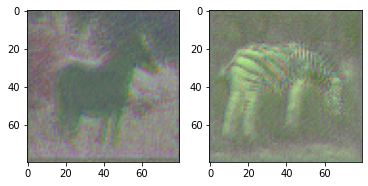

##########Iteration: 500, Scale: 0##############
Disc. real A: -1.1179797649383545 B: -0.17311221361160278
Disc fake A: 0.8368716239929199, B: -0.13763375580310822
Gradient penalty A: 0.09456901997327805, B: 0.0675378069281578
Generator adv. A: -0.9180158972740173, B: 0.08935335278511047
Cycle cons. ABA:0.11342636495828629, BAB: 0.10091729462146759
Identity AA: 0.03697879612445831, BB: 0.031054897233843803
Total var. AB: 0.015343189239501953, BA: 0.010559416376054287


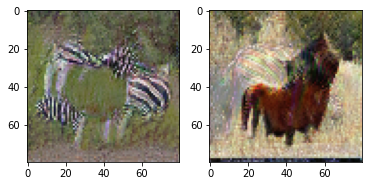

##########Iteration: 1000, Scale: 0##############
Disc. real A: -1.206296682357788 B: -0.7379631400108337
Disc fake A: 0.8456546068191528, B: 0.3861084580421448
Gradient penalty A: 0.08779093623161316, B: 0.09311546385288239
Generator adv. A: -0.9026224613189697, B: -0.4191696047782898
Cycle cons. ABA:0.11565468460321426, BAB: 0.10169309377670288
Identity AA: 0.03541923686861992, BB: 0.030656782910227776
Total var. AB: 0.016668308526277542, BA: 0.010308083146810532


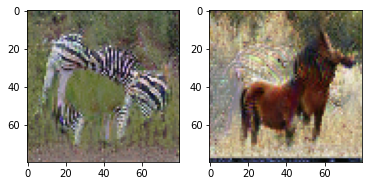

##########Iteration: 1500, Scale: 0##############
Disc. real A: -0.4057525098323822 B: -0.5318506360054016
Disc fake A: 0.1215076595544815, B: 0.12199641764163971
Gradient penalty A: 0.06468614935874939, B: 0.09068359434604645
Generator adv. A: -0.219999760389328, B: -0.14303621649742126
Cycle cons. ABA:0.10692000389099121, BAB: 0.0947355404496193
Identity AA: 0.0314808189868927, BB: 0.027847226709127426
Total var. AB: 0.016614263877272606, BA: 0.010606474243104458


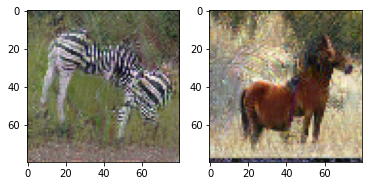

##########Iteration: 2000, Scale: 0##############
Disc. real A: -0.30080369114875793 B: -0.4107891619205475
Disc fake A: -0.051812589168548584, B: 0.0023780534975230694
Gradient penalty A: 0.08883123099803925, B: 0.10488207638263702
Generator adv. A: 0.04523559287190437, B: -0.006724405102431774
Cycle cons. ABA:0.10294243693351746, BAB: 0.0893310084939003
Identity AA: 0.026679707691073418, BB: 0.02178666554391384
Total var. AB: 0.015580949373543262, BA: 0.010177220217883587


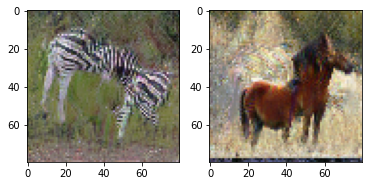

##########Iteration: 2500, Scale: 0##############
Disc. real A: -0.1909468173980713 B: -0.40222418308258057
Disc fake A: -0.15816044807434082, B: -0.01080370508134365
Gradient penalty A: 0.09395229816436768, B: 0.08958747237920761
Generator adv. A: 0.14631018042564392, B: 0.011130518279969692
Cycle cons. ABA:0.10102351754903793, BAB: 0.08788610249757767
Identity AA: 0.02620561420917511, BB: 0.02152661420404911
Total var. AB: 0.01611286960542202, BA: 0.00992241594940424


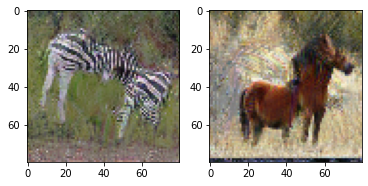

##########Iteration: 3000, Scale: 0##############
Disc. real A: -0.10642869770526886 B: -0.40845274925231934
Disc fake A: -0.22142185270786285, B: -0.006982974708080292
Gradient penalty A: 0.08814753592014313, B: 0.13681481778621674
Generator adv. A: 0.21292491257190704, B: 0.012024960480630398
Cycle cons. ABA:0.10100621730089188, BAB: 0.08787696808576584
Identity AA: 0.025698397308588028, BB: 0.021239353343844414
Total var. AB: 0.015040419064462185, BA: 0.009749654680490494


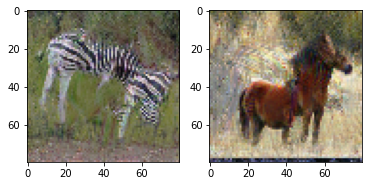

##########Iteration: 3500, Scale: 0##############
Disc. real A: -0.025795264169573784 B: -0.41632187366485596
Disc fake A: -0.31418314576148987, B: -0.008066445589065552
Gradient penalty A: 0.07593158632516861, B: 0.10332715511322021
Generator adv. A: 0.310083270072937, B: 0.006612878758460283
Cycle cons. ABA:0.09996768832206726, BAB: 0.08807578682899475
Identity AA: 0.025177396833896637, BB: 0.021323541179299355
Total var. AB: 0.015777410939335823, BA: 0.00971837155520916


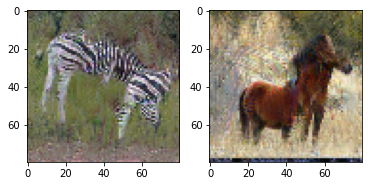

##########Iteration: 4000, Scale: 0##############
Disc. real A: 0.10710935294628143 B: -0.4025588035583496
Disc fake A: -0.46341925859451294, B: 0.029396262019872665
Gradient penalty A: 0.08587690442800522, B: 0.1552382856607437
Generator adv. A: 0.45952197909355164, B: -0.03107640892267227
Cycle cons. ABA:0.098798006772995, BAB: 0.08676964789628983
Identity AA: 0.02488485909998417, BB: 0.021355213597416878
Total var. AB: 0.015719719231128693, BA: 0.009756365790963173


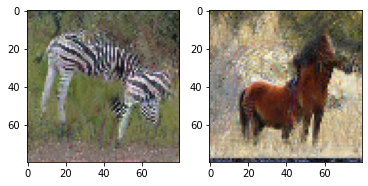

##########Iteration: 0, Scale: 1##############
Disc. real A: 0.05551552772521973 B: 0.13117364048957825
Disc fake A: -0.07806042581796646, B: -0.17962883412837982
Gradient penalty A: 0.019951069727540016, B: 0.02455560863018036
Generator adv. A: 0.05753229558467865, B: 0.20089809596538544
Cycle cons. ABA:0.24235059320926666, BAB: 0.20381733775138855
Identity AA: 0.34823817014694214, BB: 0.27605387568473816
Total var. AB: 0.0035990532487630844, BA: 0.0036805749405175447


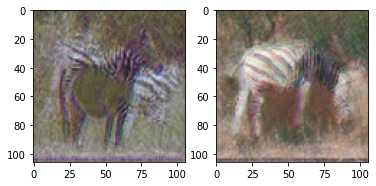

##########Iteration: 500, Scale: 1##############
Disc. real A: 0.22867955267429352 B: 0.2665880620479584
Disc fake A: -0.3895963728427887, B: -0.5474550724029541
Gradient penalty A: 0.02982395701110363, B: 0.06821151822805405
Generator adv. A: 0.38936641812324524, B: 0.48551687598228455
Cycle cons. ABA:0.10491427034139633, BAB: 0.10188254714012146
Identity AA: 0.030276790261268616, BB: 0.02225600928068161
Total var. AB: 0.014253990724682808, BA: 0.008051886223256588


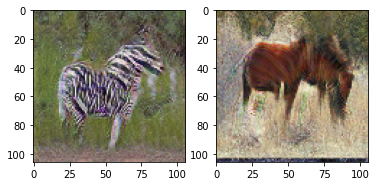

##########Iteration: 1000, Scale: 1##############
Disc. real A: 0.3200201690196991 B: 0.046315569430589676
Disc fake A: -0.5145320296287537, B: -0.35397130250930786
Gradient penalty A: 0.0436830073595047, B: 0.07494712620973587
Generator adv. A: 0.4970259964466095, B: 0.34148937463760376
Cycle cons. ABA:0.10253332555294037, BAB: 0.09491802006959915
Identity AA: 0.024921482428908348, BB: 0.019809890538454056
Total var. AB: 0.013890526257455349, BA: 0.007674416992813349


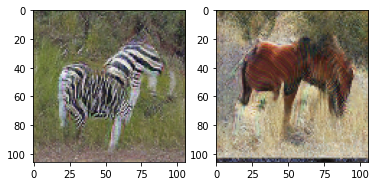

##########Iteration: 1500, Scale: 1##############
Disc. real A: 0.2009967416524887 B: -0.690434992313385
Disc fake A: -0.4115495979785919, B: 0.33932188153266907
Gradient penalty A: 0.035599954426288605, B: 0.08729850500822067
Generator adv. A: 0.41904520988464355, B: -0.3601142168045044
Cycle cons. ABA:0.10306394100189209, BAB: 0.09713763743638992
Identity AA: 0.023173198103904724, BB: 0.01927276886999607
Total var. AB: 0.01478311326354742, BA: 0.007277078926563263


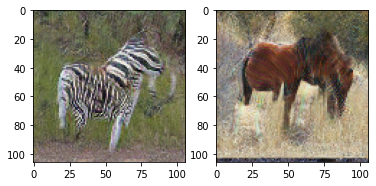

##########Iteration: 2000, Scale: 1##############
Disc. real A: 0.20333930850028992 B: -0.9023169875144958
Disc fake A: -0.4324362277984619, B: 0.5881568193435669
Gradient penalty A: 0.04419802501797676, B: 0.12307802587747574
Generator adv. A: 0.4437466561794281, B: -0.5809527635574341
Cycle cons. ABA:0.0982605516910553, BAB: 0.09067185968160629
Identity AA: 0.01948852464556694, BB: 0.015426430851221085
Total var. AB: 0.012895789928734303, BA: 0.0065642124973237514


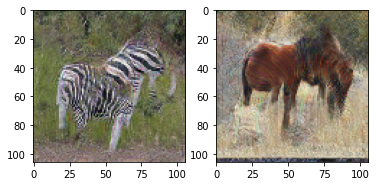

##########Iteration: 2500, Scale: 1##############
Disc. real A: 0.22577929496765137 B: -0.9859060049057007
Disc fake A: -0.45275309681892395, B: 0.6609155535697937
Gradient penalty A: 0.06290537863969803, B: 0.16656191647052765
Generator adv. A: 0.45204484462738037, B: -0.6498790979385376
Cycle cons. ABA:0.09812544286251068, BAB: 0.090891532599926
Identity AA: 0.019055228680372238, BB: 0.015312682837247849
Total var. AB: 0.013507883064448833, BA: 0.006344485562294722


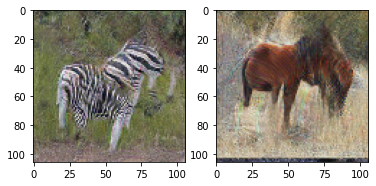

##########Iteration: 3000, Scale: 1##############
Disc. real A: 0.3643239438533783 B: -0.9518499970436096
Disc fake A: -0.5905682444572449, B: 0.6338956356048584
Gradient penalty A: 0.1086515411734581, B: 0.10074546188116074
Generator adv. A: 0.5964239835739136, B: -0.6390897631645203
Cycle cons. ABA:0.09610658138990402, BAB: 0.09046165645122528
Identity AA: 0.01872982084751129, BB: 0.015173305757343769
Total var. AB: 0.012712271884083748, BA: 0.006436403375118971


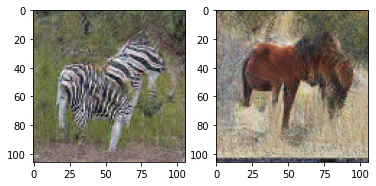

##########Iteration: 3500, Scale: 1##############
Disc. real A: 0.3888731598854065 B: -0.9035752415657043
Disc fake A: -0.5842098593711853, B: 0.5935512185096741
Gradient penalty A: 0.04455666244029999, B: 0.08751329779624939
Generator adv. A: 0.5819826126098633, B: -0.5896005034446716
Cycle cons. ABA:0.09490766376256943, BAB: 0.09112198650836945
Identity AA: 0.018687546253204346, BB: 0.014978183433413506
Total var. AB: 0.01230909675359726, BA: 0.0074328347109258175


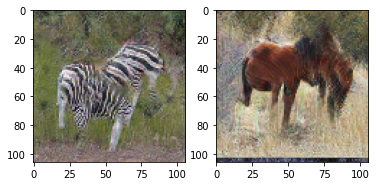

##########Iteration: 4000, Scale: 1##############
Disc. real A: 0.45211654901504517 B: -0.785956621170044
Disc fake A: -0.6576696634292603, B: 0.48873358964920044
Gradient penalty A: 0.07479619234800339, B: 0.09095154702663422
Generator adv. A: 0.661757230758667, B: -0.4922395348548889
Cycle cons. ABA:0.09321292489767075, BAB: 0.09263751655817032
Identity AA: 0.01850549504160881, BB: 0.014825996942818165
Total var. AB: 0.013077521696686745, BA: 0.007517693098634481


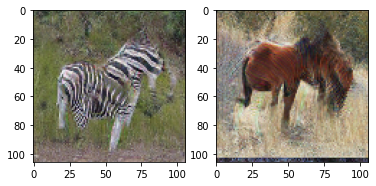

##########Iteration: 0, Scale: 2##############
Disc. real A: -0.052047550678253174 B: -0.0476863868534565
Disc fake A: 0.03319389000535011, B: 0.021608004346489906
Gradient penalty A: 0.018950602039694786, B: 0.019263675436377525
Generator adv. A: -0.0487712062895298, B: -0.007680852897465229
Cycle cons. ABA:0.21073955297470093, BAB: 0.19190046191215515
Identity AA: 0.3662433326244354, BB: 0.2793651521205902
Total var. AB: 0.003523933934047818, BA: 0.0025921075139194727


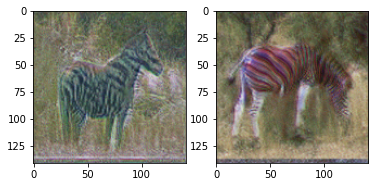

##########Iteration: 500, Scale: 2##############
Disc. real A: -0.8529850244522095 B: -0.3986305892467499
Disc fake A: 0.6950827240943909, B: 0.21771326661109924
Gradient penalty A: 0.042281657457351685, B: 0.03139033541083336
Generator adv. A: -0.7119579315185547, B: -0.3019099831581116
Cycle cons. ABA:0.10402971506118774, BAB: 0.11244899034500122
Identity AA: 0.030069487169384956, BB: 0.02313999831676483
Total var. AB: 0.010912671685218811, BA: 0.007789775729179382


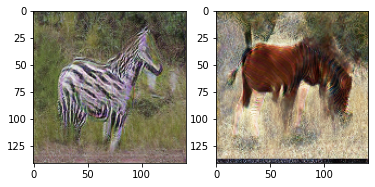

##########Iteration: 1000, Scale: 2##############
Disc. real A: -0.2661847770214081 B: -1.438510537147522
Disc fake A: 0.12104629725217819, B: 1.1945241689682007
Gradient penalty A: 0.04191678762435913, B: 0.11549748480319977
Generator adv. A: -0.14201943576335907, B: -1.1963716745376587
Cycle cons. ABA:0.103167325258255, BAB: 0.09921145439147949
Identity AA: 0.024266088381409645, BB: 0.01817767508327961
Total var. AB: 0.01193740963935852, BA: 0.007047004997730255


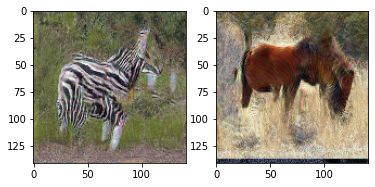

##########Iteration: 1500, Scale: 2##############
Disc. real A: -0.14053742587566376 B: -1.5560801029205322
Disc fake A: -0.02594546414911747, B: 1.3917088508605957
Gradient penalty A: 0.08037621527910233, B: 0.03261249139904976
Generator adv. A: 0.016526106745004654, B: -1.4330477714538574
Cycle cons. ABA:0.1003749668598175, BAB: 0.09393537044525146
Identity AA: 0.021636497229337692, BB: 0.01695570908486843
Total var. AB: 0.009614217095077038, BA: 0.007769578602164984


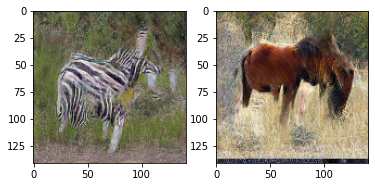

##########Iteration: 2000, Scale: 2##############
Disc. real A: -0.24174755811691284 B: -1.8225655555725098
Disc fake A: 0.07627960294485092, B: 1.5727628469467163
Gradient penalty A: 0.04828081652522087, B: 0.11544392257928848
Generator adv. A: -0.07568668574094772, B: -1.5663400888442993
Cycle cons. ABA:0.09505272656679153, BAB: 0.08399263024330139
Identity AA: 0.017553959041833878, BB: 0.01436787098646164
Total var. AB: 0.01090752612799406, BA: 0.007418762892484665


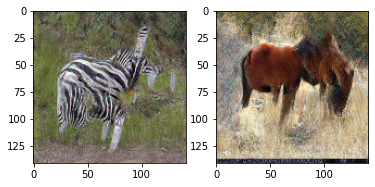

##########Iteration: 2500, Scale: 2##############
Disc. real A: -0.20361977815628052 B: -1.7671642303466797
Disc fake A: 0.04396963492035866, B: 1.5325309038162231
Gradient penalty A: 0.04383929818868637, B: 0.06975199282169342
Generator adv. A: -0.04294325038790703, B: -1.5448682308197021
Cycle cons. ABA:0.09605687856674194, BAB: 0.08405335992574692
Identity AA: 0.01715979352593422, BB: 0.014169923961162567
Total var. AB: 0.010650857351720333, BA: 0.007323863450437784


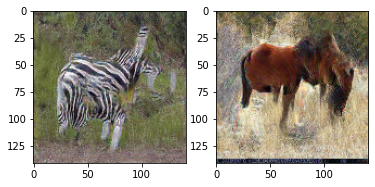

##########Iteration: 3000, Scale: 2##############
Disc. real A: -0.13045336306095123 B: -1.7575596570968628
Disc fake A: -0.02730008214712143, B: 1.5172293186187744
Gradient penalty A: 0.04550056904554367, B: 0.07519620656967163
Generator adv. A: 0.026948360726237297, B: -1.5122870206832886
Cycle cons. ABA:0.09657295048236847, BAB: 0.08393193036317825
Identity AA: 0.01673194020986557, BB: 0.013945409096777439
Total var. AB: 0.010943942703306675, BA: 0.00730331614613533


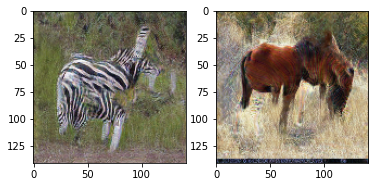

##########Iteration: 3500, Scale: 2##############
Disc. real A: -0.13839085400104523 B: -1.6695270538330078
Disc fake A: -0.027326324954628944, B: 1.4457383155822754
Gradient penalty A: 0.04894961416721344, B: 0.06945081800222397
Generator adv. A: 0.02955014258623123, B: -1.460488200187683
Cycle cons. ABA:0.09568054229021072, BAB: 0.08385466784238815
Identity AA: 0.016467228531837463, BB: 0.013879533857107162
Total var. AB: 0.010672694072127342, BA: 0.007431396283209324


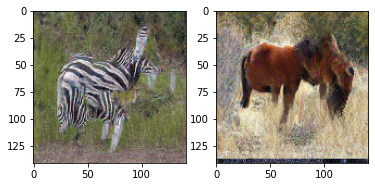

##########Iteration: 4000, Scale: 2##############
Disc. real A: -0.04401012137532234 B: -1.7109911441802979
Disc fake A: -0.10741426050662994, B: 1.4782943725585938
Gradient penalty A: 0.037095263600349426, B: 0.11363126337528229
Generator adv. A: 0.10771689563989639, B: -1.4826362133026123
Cycle cons. ABA:0.09544240683317184, BAB: 0.08166493475437164
Identity AA: 0.01610257476568222, BB: 0.01350927259773016
Total var. AB: 0.011032492853701115, BA: 0.007412842940539122


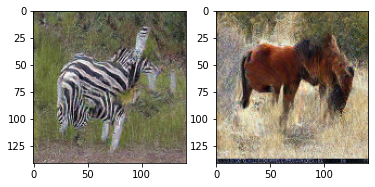

##########Iteration: 0, Scale: 3##############
Disc. real A: 0.07669292390346527 B: 0.09744130074977875
Disc fake A: -0.09732400625944138, B: -0.13256901502609253
Gradient penalty A: 0.021799316629767418, B: 0.019008338451385498
Generator adv. A: 0.06503099948167801, B: 0.16126134991645813
Cycle cons. ABA:0.18749459087848663, BAB: 0.16277924180030823
Identity AA: 0.32407712936401367, BB: 0.24806879460811615
Total var. AB: 0.0031786721665412188, BA: 0.0033997034188359976


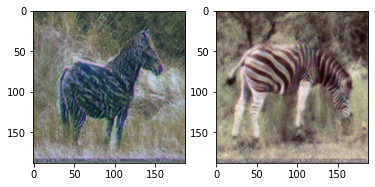

##########Iteration: 500, Scale: 3##############
Disc. real A: -0.48377498984336853 B: -0.06391575932502747
Disc fake A: 0.3662010431289673, B: -0.08830425888299942
Gradient penalty A: 0.030034253373742104, B: 0.0530698262155056
Generator adv. A: -0.3818158805370331, B: 0.09827635437250137
Cycle cons. ABA:0.09130460023880005, BAB: 0.0894223004579544
Identity AA: 0.023553909733891487, BB: 0.017483647912740707
Total var. AB: 0.007303758058696985, BA: 0.004687735810875893


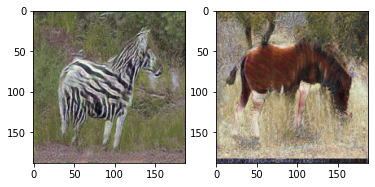

##########Iteration: 1000, Scale: 3##############
Disc. real A: -0.4006693661212921 B: -0.127744659781456
Disc fake A: 0.26799577474594116, B: -0.02385842613875866
Gradient penalty A: 0.040305864065885544, B: 0.047238823026418686
Generator adv. A: -0.31747183203697205, B: 0.011179064400494099
Cycle cons. ABA:0.09142015129327774, BAB: 0.08865395933389664
Identity AA: 0.02027086541056633, BB: 0.015763187780976295
Total var. AB: 0.006414549890905619, BA: 0.004397333133965731


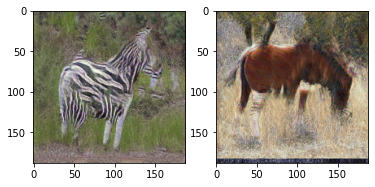

##########Iteration: 1500, Scale: 3##############
Disc. real A: -0.4210852086544037 B: -0.3096303939819336
Disc fake A: 0.31451570987701416, B: 0.13880930840969086
Gradient penalty A: 0.04434090480208397, B: 0.04499059543013573
Generator adv. A: -0.3668968379497528, B: -0.16462165117263794
Cycle cons. ABA:0.08867667615413666, BAB: 0.08671200275421143
Identity AA: 0.018067341297864914, BB: 0.014869168400764465
Total var. AB: 0.0074104368686676025, BA: 0.0042988816276192665


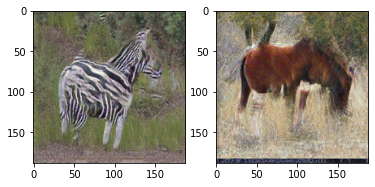

##########Iteration: 2000, Scale: 3##############
Disc. real A: -0.4995509088039398 B: -0.3091539144515991
Disc fake A: 0.3802914023399353, B: 0.1304892748594284
Gradient penalty A: 0.050152428448200226, B: 0.05247580632567406
Generator adv. A: -0.37757861614227295, B: -0.13415215909481049
Cycle cons. ABA:0.08263204991817474, BAB: 0.08151783794164658
Identity AA: 0.015801530331373215, BB: 0.011802594177424908
Total var. AB: 0.0064755999483168125, BA: 0.004221817012876272


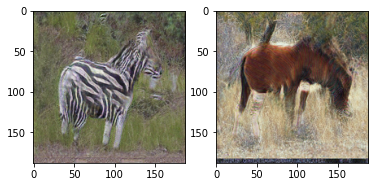

##########Iteration: 2500, Scale: 3##############
Disc. real A: -0.49291738867759705 B: -0.3814142048358917
Disc fake A: 0.37311622500419617, B: 0.20845843851566315
Gradient penalty A: 0.03453381359577179, B: 0.06783279031515121
Generator adv. A: -0.3699546456336975, B: -0.21068328619003296
Cycle cons. ABA:0.082408607006073, BAB: 0.08020360767841339
Identity AA: 0.015311525203287601, BB: 0.011607715860009193
Total var. AB: 0.006207324098795652, BA: 0.00411995081230998


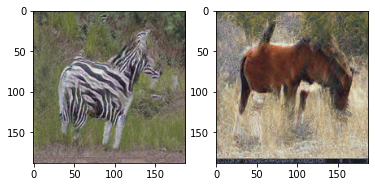

##########Iteration: 3000, Scale: 3##############
Disc. real A: -0.519126296043396 B: -0.41644445061683655
Disc fake A: 0.3968534469604492, B: 0.23153352737426758
Gradient penalty A: 0.029542509466409683, B: 0.05129314213991165
Generator adv. A: -0.40165388584136963, B: -0.23885324597358704
Cycle cons. ABA:0.08419223129749298, BAB: 0.080180324614048
Identity AA: 0.014899162575602531, BB: 0.011459208093583584
Total var. AB: 0.006521546747535467, BA: 0.004082282539457083


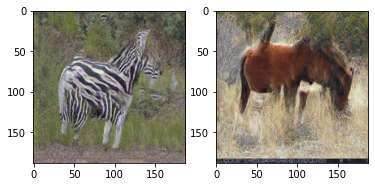

##########Iteration: 3500, Scale: 3##############
Disc. real A: -0.49095484614372253 B: -0.3971955180168152
Disc fake A: 0.3685193359851837, B: 0.22513185441493988
Gradient penalty A: 0.027354752644896507, B: 0.05002138763666153
Generator adv. A: -0.3788500428199768, B: -0.22234435379505157
Cycle cons. ABA:0.0832517072558403, BAB: 0.07955135405063629
Identity AA: 0.014615454711019993, BB: 0.011345659382641315
Total var. AB: 0.006177408620715141, BA: 0.0039859735406935215


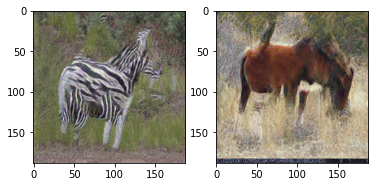

##########Iteration: 4000, Scale: 3##############
Disc. real A: -0.47782817482948303 B: -0.3712249994277954
Disc fake A: 0.3578406870365143, B: 0.20134685933589935
Gradient penalty A: 0.03580678254365921, B: 0.06229513883590698
Generator adv. A: -0.35757604241371155, B: -0.19831979274749756
Cycle cons. ABA:0.08243244141340256, BAB: 0.07791740447282791
Identity AA: 0.014317714609205723, BB: 0.01113186590373516
Total var. AB: 0.006413180381059647, BA: 0.004052135162055492


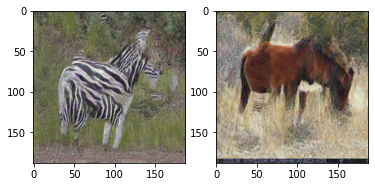

##########Iteration: 0, Scale: 4##############
Disc. real A: 0.03169966861605644 B: 0.05776400491595268
Disc fake A: -0.05362396314740181, B: -0.0922403335571289
Gradient penalty A: 0.026735037565231323, B: 0.018426841124892235
Generator adv. A: 0.018763191998004913, B: 0.10960279405117035
Cycle cons. ABA:0.18499942123889923, BAB: 0.17899829149246216
Identity AA: 0.3499457836151123, BB: 0.298307329416275
Total var. AB: 0.0030533839017152786, BA: 0.002664255676791072


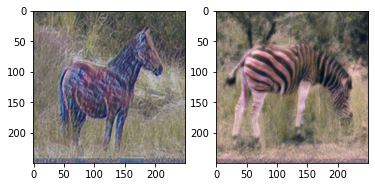

##########Iteration: 500, Scale: 4##############
Disc. real A: -0.38960111141204834 B: 0.09737464040517807
Disc fake A: 0.2778835594654083, B: -0.23683632910251617
Gradient penalty A: 0.036783330142498016, B: 0.049771491438150406
Generator adv. A: -0.2912743091583252, B: 0.24033081531524658
Cycle cons. ABA:0.08283917605876923, BAB: 0.0748063176870346
Identity AA: 0.023167364299297333, BB: 0.015518734231591225
Total var. AB: 0.0047130524180829525, BA: 0.0038380452897399664


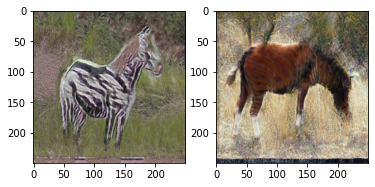

##########Iteration: 1000, Scale: 4##############
Disc. real A: -0.3273032605648041 B: -0.1747230887413025
Disc fake A: 0.226943239569664, B: 0.040251683443784714
Gradient penalty A: 0.026940522715449333, B: 0.043215613812208176
Generator adv. A: -0.24554193019866943, B: -0.05660738795995712
Cycle cons. ABA:0.08373904973268509, BAB: 0.07455998659133911
Identity AA: 0.019954262301325798, BB: 0.014739017002284527
Total var. AB: 0.004677569027990103, BA: 0.0036593822296708822


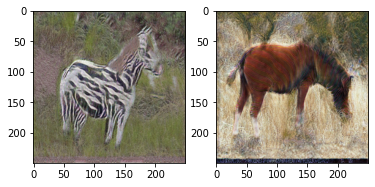

##########Iteration: 1500, Scale: 4##############
Disc. real A: -0.13353684544563293 B: -0.2057163119316101
Disc fake A: 0.03347059339284897, B: 0.08969748765230179
Gradient penalty A: 0.054373759776353836, B: 0.03156181797385216
Generator adv. A: -0.1201205924153328, B: -0.11205607652664185
Cycle cons. ABA:0.07734793424606323, BAB: 0.0715654194355011
Identity AA: 0.017916327342391014, BB: 0.012960012070834637
Total var. AB: 0.004191494546830654, BA: 0.0033625296782702208


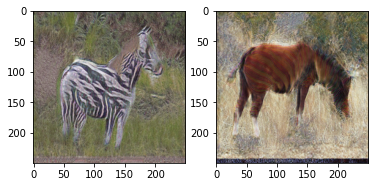

##########Iteration: 2000, Scale: 4##############
Disc. real A: -0.21096569299697876 B: -0.32643696665763855
Disc fake A: 0.12120097130537033, B: 0.16140206158161163
Gradient penalty A: 0.030378231778740883, B: 0.07063464820384979
Generator adv. A: -0.12168451398611069, B: -0.1653502881526947
Cycle cons. ABA:0.07402704656124115, BAB: 0.06837593764066696
Identity AA: 0.014863308519124985, BB: 0.011081096716225147
Total var. AB: 0.006505947560071945, BA: 0.0032160195987671614


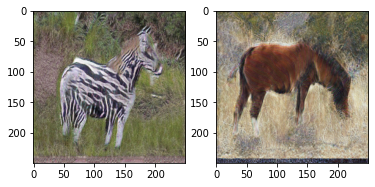

##########Iteration: 2500, Scale: 4##############
Disc. real A: -0.19507278501987457 B: -0.36724743247032166
Disc fake A: 0.11375874280929565, B: 0.1929069310426712
Gradient penalty A: 0.02212119661271572, B: 0.12260949611663818
Generator adv. A: -0.12010683119297028, B: -0.17980584502220154
Cycle cons. ABA:0.07441909611225128, BAB: 0.06816767901182175
Identity AA: 0.014440756291151047, BB: 0.011070692911744118
Total var. AB: 0.007870549336075783, BA: 0.0030936230905354023


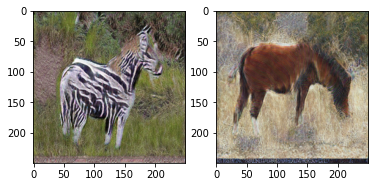

##########Iteration: 3000, Scale: 4##############
Disc. real A: -0.22267618775367737 B: -0.20539477467536926
Disc fake A: 0.13154689967632294, B: 0.029966551810503006
Gradient penalty A: 0.042924534529447556, B: 0.040683820843696594
Generator adv. A: -0.12133102864027023, B: -0.03489692136645317
Cycle cons. ABA:0.07476724684238434, BAB: 0.06800098717212677
Identity AA: 0.013985308818519115, BB: 0.011109758168458939
Total var. AB: 0.008094294928014278, BA: 0.002946857362985611


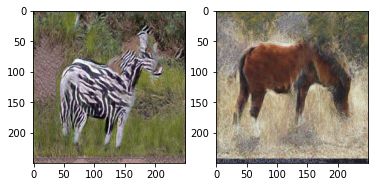

##########Iteration: 3500, Scale: 4##############
Disc. real A: -0.22288371622562408 B: -0.11567848175764084
Disc fake A: 0.13102956116199493, B: -0.033416420221328735
Gradient penalty A: 0.023650523275136948, B: 0.03759143874049187
Generator adv. A: -0.13500291109085083, B: 0.023412400856614113
Cycle cons. ABA:0.07401297986507416, BAB: 0.0679502785205841
Identity AA: 0.013608668930828571, BB: 0.01083348598331213
Total var. AB: 0.008198488503694534, BA: 0.0029336411971598864


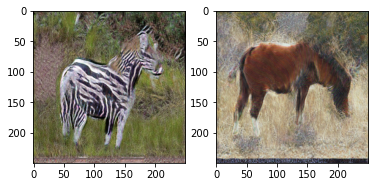

##########Iteration: 4000, Scale: 4##############
Disc. real A: -0.19598238170146942 B: -0.11300591379404068
Disc fake A: 0.11380083113908768, B: -0.05505111813545227
Gradient penalty A: 0.018625080585479736, B: 0.04391660913825035
Generator adv. A: -0.11167056858539581, B: 0.0644160807132721
Cycle cons. ABA:0.07420111447572708, BAB: 0.06724599748849869
Identity AA: 0.013366895727813244, BB: 0.01056156400591135
Total var. AB: 0.008604618720710278, BA: 0.002874332247301936


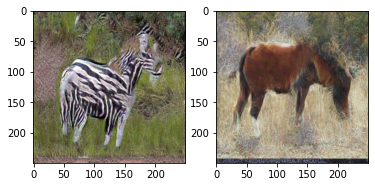

In [7]:
# Generate model list with initial weights.
listg_ab, listg_ba, listd_a, listd_b = create_models(num_scale=NUM_SCALES, device=DEVICE)

# Start training.
train(listA, listB, (listg_ab, listg_ba, listd_a, listd_b))

## Save Models

In [9]:
# Save final models to 'models' directory.
save_models(listg_ab, listg_ba, listd_a, listd_b, data_name)

## Some Qualitative Results

Under this title, generated images from saved models are shown. Our qualitative goal is horse to zebra output. (Figure 4 in paper.)

![goal](imgs/horse2zebra.png)

### Horse to zebra outputs

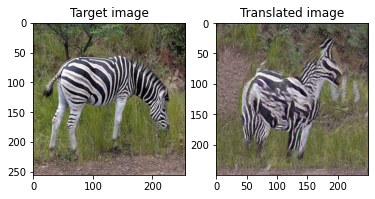

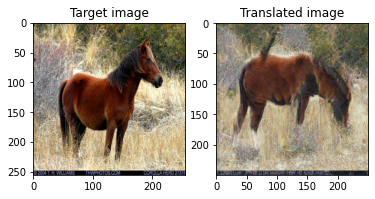

Sifid score for zebra to horse -> 0.5975121890812005, horse to zebra -> 0.21327324034282924


In [13]:
# Sifid loads inception model, so first run will download inception and will take time.
sifid = SIFID()
sifid_scores = []

data_name = 'horse2zebra'

pathA = f'{data_name}_A.jpg'
pathB = f'{data_name}_B.jpg'
listA, listB = load_images(path_a=pathA, path_b=pathB)

# Load pretrained model weights.
listg_ab, listg_ba, listd_a, listd_b = load_models(data_name, device=DEVICE)

# Visualize output of each scale for given input pairs.
curr_ab, curr_ba = generate_outputs((listA, listB), (listg_ab, listg_ba, listd_a, listd_b), NUM_SCALES - 1)

# Save images to use in sifid
curr_ab.save(f"{data_name}_translated_ab.jpg")
curr_ba.save(f"{data_name}_translated_ba.jpg")


img_B = Image.open(f'data/{data_name}_B.jpg').convert('RGB')
plt.subplot(1, 2, 1)
plt.title('Target image')
plt.imshow(img_B)

plt.subplot(1, 2, 2)
plt.title('Translated image')
plt.imshow(curr_ab)
plt.show()

img_A = Image.open(f'data/{data_name}_A.jpg').convert('RGB')
plt.subplot(1, 2, 1)
plt.title('Target image')
plt.imshow(img_A)

plt.subplot(1, 2, 2)
plt.title('Translated image')
plt.imshow(curr_ba)
plt.show()

sifid_B = sifid.calculate_sifid(f'{data_name}_translated_ab.jpg', 
                                    f'data/{data_name}_B.jpg')

sifid_A = sifid.calculate_sifid(f'{data_name}_translated_ba.jpg', 
                                    f'data/{data_name}_A.jpg')

sifid_scores.append(sifid_A)
sifid_scores.append(sifid_B)

print(f'Sifid score for zebra to horse -> {sifid_A}, horse to zebra -> {sifid_B}')

### Facade to labels

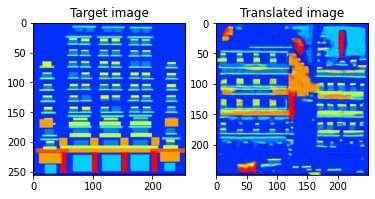

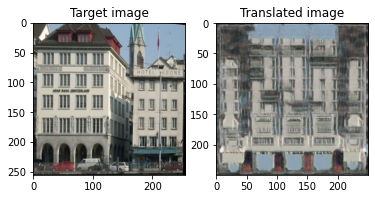

Sifid score for labels to facade -> 0.54518354410245, facade to labels -> 0.2151797610355075


In [14]:
data_name = 'facade2labels'

pathA = f'{data_name}_A.jpg'
pathB = f'{data_name}_B.jpg'
listA, listB = load_images(path_a=pathA, path_b=pathB)

# Load pretrained model weights.
listg_ab, listg_ba, listd_a, listd_b = load_models(data_name, device=DEVICE)

# Visualize output of each scale for given input pairs.
curr_ab, curr_ba = generate_outputs((listA, listB), (listg_ab, listg_ba, listd_a, listd_b), NUM_SCALES - 1)

# Save images to use in sifid
curr_ab.save(f"{data_name}_translated_ab.jpg")
curr_ba.save(f"{data_name}_translated_ba.jpg")


img_B = Image.open(f'data/{data_name}_B.jpg').convert('RGB')
plt.subplot(1, 2, 1)
plt.title('Target image')
plt.imshow(img_B)

plt.subplot(1, 2, 2)
plt.title('Translated image')
plt.imshow(curr_ab)
plt.show()

img_A = Image.open(f'data/{data_name}_A.jpg').convert('RGB')
plt.subplot(1, 2, 1)
plt.title('Target image')
plt.imshow(img_A)

plt.subplot(1, 2, 2)
plt.title('Translated image')
plt.imshow(curr_ba)
plt.show()

sifid_B = sifid.calculate_sifid(f'{data_name}_translated_ab.jpg', 
                                    f'data/{data_name}_B.jpg')

sifid_A = sifid.calculate_sifid(f'{data_name}_translated_ba.jpg', 
                                    f'data/{data_name}_A.jpg')

sifid_scores.append(sifid_A)
sifid_scores.append(sifid_B)



print(f'Sifid score for labels to facade -> {sifid_A}, facade to labels -> {sifid_B}')

### Apple to orange

Due to last time model saving issues, we lost our trained models.
We could only save apple to orange trained model.
Our trained model can be loaded and inference code can be run by using below cell.

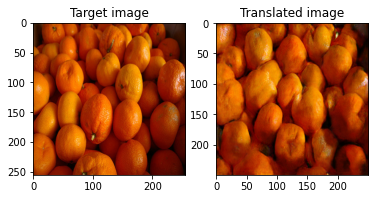

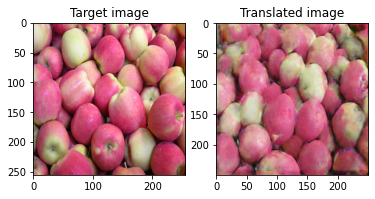

Sifid score for orange to apple -> 0.1417949560437144, apple to orange -> 0.05477933520942102


In [15]:
data_name = 'apple2orange'

pathA = f'{data_name}_A.jpg'
pathB = f'{data_name}_B.jpg'
listA, listB = load_images(path_a=pathA, path_b=pathB)

# Load pretrained model weights.
listg_ab, listg_ba, listd_a, listd_b = load_models(data_name, device=DEVICE)

# Visualize output of each scale for given input pairs.
curr_ab, curr_ba = generate_outputs((listA, listB), (listg_ab, listg_ba, listd_a, listd_b), NUM_SCALES - 1)

# Save images to use in sifid
curr_ab.save(f"{data_name}_translated_ab.jpg")
curr_ba.save(f"{data_name}_translated_ba.jpg")


img_B = Image.open(f'data/{data_name}_B.jpg').convert('RGB')
plt.subplot(1, 2, 1)
plt.title('Target image')
plt.imshow(img_B)

plt.subplot(1, 2, 2)
plt.title('Translated image')
plt.imshow(curr_ab)
plt.show()

img_A = Image.open(f'data/{data_name}_A.jpg').convert('RGB')
plt.subplot(1, 2, 1)
plt.title('Target image')
plt.imshow(img_A)

plt.subplot(1, 2, 2)
plt.title('Translated image')
plt.imshow(curr_ba)
plt.show()

sifid_B = sifid.calculate_sifid(f'{data_name}_translated_ab.jpg', 
                                    f'data/{data_name}_B.jpg')

sifid_A = sifid.calculate_sifid(f'{data_name}_translated_ba.jpg', 
                                    f'data/{data_name}_A.jpg')

sifid_scores.append(sifid_A)
sifid_scores.append(sifid_B)

print(f'Sifid score for orange to apple -> {sifid_A}, apple to orange -> {sifid_B}')

### Targeted Quantitative Results

We aim to reproduce this SIFID results published in paper. 

![sifid](imgs/sifid.png)

Our mean SIFID score can be seen below.

In [17]:
avg_scores = sum(sifid_scores)/len(sifid_scores)
print(f'Mean sifid scores -> {avg_scores}')

Mean sifid scores -> 0.29462050430252046


# Implementation Challenges

## Related to paper

### The paper only tells us about the general framework. There is a little information about training and implementation. 
* Authors only provided the layer count, kernel size, stride and padding information about the generators and discriminators. There was no information about filter count, so we conducted several experiments with 8, 16 and 32 filter count for each layer. Since the training is very costly, we decided the filter count by looking at the coarsest level outputs. We ended up with using 32 filter count in each layer.
* About training procedure, the paper tells us only the learning rate and its decay. There is no any other information about training. Therefore, since the whole architectures consists of conv layers, we adapt the DCGAN suggestions. Also, we can say that TuiGAN is some sort built on top of SinGAN. The authors of SinGAN have provided sufficient amount of information to conduct training in theirs supplementary material, so we follow SinGAN's training procedure details.
* After some experiments, we saw that weight initialization is very very crucial. The weight initilazation techniques that is used in DCGAN helped a lot to stabilize the training. Without initialization, we mostly ended up with bad qualitative results. The paper does not contain any information about weight initialization.
* [DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#weight-initialization) tricks that we followed. Here is the [SinGAN](https://tamarott.github.io/SinGAN.htm)'s project page, you can find the supplementay materials and its paper in there.
* While constructing the image scale pyramids, upsampling method is provided but there was no information about downsampling.

### Direct implementation of total variation loss is not applicable.
* Due to the square root in the total variation loss, the training sometimes crashes with NaN gradient values. Therefore, we followed tensorflow's official TV loss implementation. [Tensorflow TV loss](https://github.com/tensorflow/tensorflow/blob/v2.5.0/tensorflow/python/ops/image_ops_impl.py#L3287-L3356)

### Images that are used in the evaluation does not provided.
* The authors do not provide their dataset, we found their examples by searching the available datasets out there.

### SIFID Implementaion
* SinGAN was referenced about SIFID. When we implement the SinGAN's approach, we saw that qualitative results and quantitative results are not so correlated. They claimed that average SIFID score is $0.080x10^-2$. However, in original SinGAN paper they have calculated SinGAN's SIFID score  0.09  which is calculated between just noticable differences.(For example, please refer to [SinGAN](https://tamarott.github.io/SinGAN.htm)) project page. We believe that they used some any other layer of Inception to calculate SIFID, but they have not provide any information about it.

## Others

### Memory Issues
* We start with pytorch==1.7.1 and python3.8. However, while using autograd to compute gradient penalty, memory leak was happening due to the extra graph creation. Detecting the issue was hard. We solved it by incrementing the pytorch version to 1.8.1 and degrading the python3.8 to python3.6
* Due to the two scale pyramids of generators and discriminators, handling the memory usage slowed down us.

### Model Loading
* While loading the model, we couldn't reproduce the same results with training at first. Because we used batch norm, when we change the model to eval mode, it produces different result from train mode. So we changed first 4 scales to eval mode and last layer remained in train mode.